# DEMAND FORECASTING WITH SALES DATA

In [2]:
import pandas as pd
df1=pd.read_csv('assignment4.1a.csv',parse_dates=['Date'])
df3=pd.read_csv('assignment4.1b.csv',parse_dates=['Date'])
df2=pd.read_csv('assignment4.1c.csv')
df4=pd.read_csv('PromotionDates.csv',parse_dates=['StartDate','EndDate'])

In [12]:
dfs=[df1,df2,df3,df4]
for i in dfs:
    print(i)
    print(i.info())
    print(i.isnull().sum())

              Date  StoreCode  ProductCode  SalesQuantity
0       2015-01-01          8            9             -1
1       2015-01-01        131            9              1
2       2015-01-01        144            9              2
3       2015-01-01        203            9              2
4       2015-01-01        256            9              0
...            ...        ...          ...            ...
1873613 2015-07-30        292          315              0
1873614 2015-07-31         12          315              1
1873615 2015-07-31        104          315              1
1873616 2015-07-31        261          315              1
1873617 2015-07-31        295          315              1

[1873618 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873618 entries, 0 to 1873617
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   StoreCode      int64         
 2   ProductCode    int6

In [3]:
# merge product group 1 and group 2 infos from df2 to sales DataFrame (df1)
result=df1.merge(df2, how='left',on='ProductCode')
result.head()

,Date,StoreCode,ProductCode,SalesQuantity,ProductGroup1,ProductGroup2
0,2015-01-01,8,9,-1,H,15
1,2015-01-01,131,9,1,H,15
2,2015-01-01,144,9,2,H,15
3,2015-01-01,203,9,2,H,15
4,2015-01-01,256,9,0,H,15


#### Group sales according to promotion
I'm taking account of first 4 promotions while grouping.

In [22]:
df4

,Period,StartDate,EndDate
0,Promo1,2015-02-10,2015-02-17
1,Promo2,2015-03-15,2015-03-22
2,Promo3,2015-05-24,2015-06-01
3,Promo4,2015-06-21,2015-06-28
4,Promo5,2015-01-09,2015-06-09
5,Promo6,2015-11-20,2015-11-27


In [4]:
import numpy as np
promotions=[
    (result['Date']<='2015-02-17')&(result['Date']>='2015-02-10'),
    (result['Date']<='2015-03-22')&(result['Date']>='2015-03-15'),
    (result['Date']<='2015-06-01')&(result['Date']>='2015-05-24'),
    (result['Date']<='2015-06-28')&(result['Date']>='2015-06-21')]
labels=['Promo_1','Promo_2','Promo_3','Promo_4']
result['promotions'] = np.select(promotions, labels)

In [5]:
result.promotions=result.promotions.replace(['0'],['No_Promo'])

In [6]:
result.promotions.value_counts()

No_Promo    1562695
Promo_2       85678
Promo_1       80876
Promo_3       76546
Promo_4       67823
Name: promotions, dtype: int64

In [7]:
result.promotions.value_counts(normalize=True)

No_Promo    0.834052
Promo_2     0.045729
Promo_1     0.043166
Promo_3     0.040855
Promo_4     0.036199
Name: promotions, dtype: float64

# Fast, Slow and Medium Items
"Product with higher average weekly sale per store during non-promotion periods will be called “Fast items” and items with lower weekly average sale per store will be labeled as “Slow items”, items in between will be called “Medium items” ".

In [9]:
non_promotional_sales=result[result['promotions']=='No_Promo']

####  Average Non-Promotional Weekly Sales (Productwise)

In [10]:
product_np=non_promotional_sales.groupby(['ProductCode',pd.Grouper(key='Date', freq='W-MON')])['SalesQuantity'].mean().reset_index()

#### Average Non-Promotional Weekly Sales (Storewise)

In [11]:
store_np=non_promotional_sales.groupby(['StoreCode',pd.Grouper(key='Date', freq='W-MON')])['SalesQuantity'].mean().reset_index()

In [12]:
store_np=store_np.groupby('StoreCode')['SalesQuantity'].mean().reset_index()
store_np.head()

,StoreCode,SalesQuantity
0,1,2.222049
1,2,3.296651
2,3,1.675917
3,4,1.998771
4,5,1.721870


In [13]:
product_np=product_np.groupby('ProductCode')['SalesQuantity'].mean().reset_index()
product_np.head()

,ProductCode,SalesQuantity
0,1,2.342714
1,2,2.200469
2,3,1.784661
3,4,2.151840
4,5,1.974442


The distribution of data points for each group:

In [14]:
import matplotlib.pyplot as plt
pd.Series(store_np.SalesQuantity).plot(kind='hist')

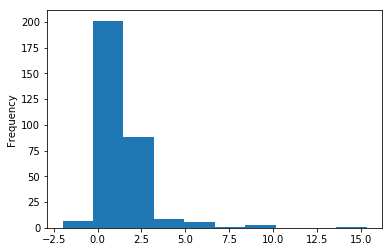

In [15]:
pd.Series(product_np.SalesQuantity).plot(kind='hist')

Average weekly sales are not distributed normally, I used quantiles to rank data into 3 groups. Data points smaller that 0.25  quantile is slow, higher than 0.75 quantile is fast, between quantiles is medium.

In [16]:
store_np['SalesQuantity'].quantile([.25,.75])

0.25    1.763922
0.75    2.366371
Name: SalesQuantity, dtype: float64

In [17]:
product_np['SalesQuantity'].quantile([.25,.75])

0.25    0.511731
0.75    1.801473
Name: SalesQuantity, dtype: float64

In [18]:
store_np['groups'] = np.select([store_np['SalesQuantity'] <1.763922, store_np['SalesQuantity']> 2.366371],['slow', 'fast'], 'medium')

In [19]:
product_np['groups'] = np.select([product_np['SalesQuantity'] <0.511731, product_np['SalesQuantity']> 1.801473],['slow', 'fast'], 'medium')

In [20]:
store_np.head()

,StoreCode,SalesQuantity,groups
0,1,2.222049,medium
1,2,3.296651,fast
2,3,1.675917,slow
3,4,1.998771,medium
4,5,1.721870,slow


In [21]:
product_np.head()

,ProductCode,SalesQuantity,groups
0,1,2.342714,fast
1,2,2.200469,fast
2,3,1.784661,medium
3,4,2.151840,fast
4,5,1.974442,fast


In [22]:
fast_items=product_np[product_np['groups']=='fast']['ProductCode'].to_list()
slow_items=product_np[product_np['groups']=='slow']['ProductCode'].to_list()
medium_items=product_np[product_np['groups']=='medium']['ProductCode'].to_list()

In [23]:
dict_items={'fast':fast_items, 'slow':slow_items,'medium':medium_items}

In [24]:
fast_stores=store_np[store_np['groups']=='fast']['StoreCode'].to_list()
slow_stores=store_np[store_np['groups']=='slow']['StoreCode'].to_list()
medium_stores=store_np[store_np['groups']=='medium']['StoreCode'].to_list()

In [25]:
dict_stores={'fast':fast_stores, 'slow':slow_stores,'medium':medium_stores}

# Which items experienced the biggest sale increase during promotions?

In [26]:
all_data=result

In [27]:
all_data['is_promotion']=np.where(all_data['promotions']!='No_Promo',True,False)

In [28]:
d = {val:key for key, lst in dict_stores.items() for val in lst}
all_data['store_groups'] = all_data.StoreCode.map(d)

In [29]:
d = {val:key for key, lst in dict_items.items() for val in lst}
all_data['product_groups'] = all_data.ProductCode.map(d)

In [30]:
all_data.head()

,Date,StoreCode,ProductCode,SalesQuantity,ProductGroup1,ProductGroup2,promotions,is_promotion,store_groups,product_groups
0,2015-01-01,8,9,-1,H,15,No_Promo,False,medium,slow
1,2015-01-01,131,9,1,H,15,No_Promo,False,medium,slow
2,2015-01-01,144,9,2,H,15,No_Promo,False,slow,slow
3,2015-01-01,203,9,2,H,15,No_Promo,False,slow,slow
4,2015-01-01,256,9,0,H,15,No_Promo,False,fast,slow


In [20]:
all_data[all_data.is_promotion==False].groupby('ProductCode')['SalesQuantity'].sum()

ProductCode
1      9435
2      7114
3      5173
4      6320
5      7627
       ... 
313    6070
314     671
315     462
316     974
317     390
Name: SalesQuantity, Length: 316, dtype: int64

In [21]:
all_data[all_data.is_promotion==True].groupby('ProductCode')['SalesQuantity'].mean()

ProductCode
1      2.421702
2      2.340223
3      2.000000
4      2.175747
5      2.365607
         ...   
313    2.380198
314    0.565041
315    0.502222
316    0.577957
317    0.426056
Name: SalesQuantity, Length: 301, dtype: float64

In [290]:
((all_data[all_data.is_promotion==True].groupby('ProductCode')['SalesQuantity'].mean()-all_data[all_data.is_promotion==False].groupby('ProductCode')['SalesQuantity'].mean())/all_data[all_data.is_promotion==False].groupby('ProductCode')['SalesQuantity'].mean()*100).nlargest(10)

ProductCode
231    260.703812
192    206.666667
55     204.761905
291    200.000000
22     171.810972
229    164.705882
270    129.191321
61     115.425532
271    114.973262
269     98.412698
Name: SalesQuantity, dtype: float64

These items have experienced the biggest average sale increase during the promotions.

In [291]:
((all_data[all_data.is_promotion==True].groupby('product_groups')['SalesQuantity'].mean()-all_data[all_data.is_promotion==False].groupby('product_groups')['SalesQuantity'].mean())/all_data[all_data.is_promotion==False].groupby('product_groups')['SalesQuantity'].mean()*100).nlargest(10)

product_groups
fast      26.859761
slow      19.081674
medium    12.156978
Name: SalesQuantity, dtype: float64

fast average product sales increases 8 times more than as medium products.

# Are there stores that have higher promotion reaction? 

#### Percent Average Sale Changes for Stores in Promotional and Non-Promotional Periods

In [51]:
(all_data[all_data.is_promotion==True].groupby('StoreCode')['SalesQuantity'].mean()-all_data[all_data.is_promotion==False].groupby('StoreCode')['SalesQuantity'].mean()).nlargest(10)

StoreCode
92     2.914637
256    1.880617
205    1.519290
181    1.445752
155    1.318962
117    1.286733
21     1.212632
275    1.138896
318    1.136709
284    1.128289
Name: SalesQuantity, dtype: float64

Some stores increases average quantity sales up to %33.8.

In [63]:
x=all_data[all_data.is_promotion==True].groupby('StoreCode')['SalesQuantity'].mean().reset_index()

In [66]:
x.columns='Stores','Promotional_avarage_sales'

In [67]:
y=all_data[all_data.is_promotion==False].groupby('StoreCode')['SalesQuantity'].mean().reset_index()

In [68]:
y.columns='Stores','Non-promotional_average_sales'

In [70]:
result=x.merge(y, on='Stores',how='left')

In [75]:
result['perc_change']=(result['Promotional_avarage_sales']-result['Non-promotional_average_sales'])/result['Non-promotional_average_sales']*100

In [77]:
(result['perc_change']>0).value_counts(normalize=True)

True     0.860119
False    0.139881
Name: perc_change, dtype: float64

87 % of stores increased their average sales with promotions.

In [52]:
import plotly.express as px
t=(all_data.groupby(['StoreCode','is_promotion',pd.Grouper(key='Date', freq='W-MON')])['SalesQuantity'].mean()).reset_index()
t=t.groupby(['StoreCode','is_promotion'])['SalesQuantity'].mean().reset_index()
table = pd.pivot_table(t, values='SalesQuantity', index=['StoreCode'],
                    columns=['is_promotion'], aggfunc=np.mean, fill_value=0)
table['Percent Sales Changes']=((table[True]-table[False])/table[False])*100
table['Percent Sales Changes']=round(table['Percent Sales Changes'],2)
fig = px.bar(table, x=table.index, y=table['Percent Sales Changes'], title="Percent Average Weekly Sales Change Per Store After Promotions")
fig.show()

Average sales of Store 92 increased by 141.63 percent, while store 130 decreased by 100 percent.

#  Is there any significant difference between promotion impacts of the Fast versus Slow stores?

In [59]:
all_data.is_promotion.value_counts()

False    1562695
True      310923
Name: is_promotion, dtype: int64

True for promotional periods, False for non-promotional periods.

In [43]:
all_data.head()

,Date,StoreCode,ProductCode,SalesQuantity,ProductGroup1,ProductGroup2,promotions,store_groups,product_groups,is_promotion
0,2015-01-01,8,9,-1,H,15,No_Promo,medium,slow,False
1,2015-01-01,131,9,1,H,15,No_Promo,medium,slow,False
2,2015-01-01,144,9,2,H,15,No_Promo,slow,slow,False
3,2015-01-01,203,9,2,H,15,No_Promo,slow,slow,False
4,2015-01-01,256,9,0,H,15,No_Promo,fast,slow,False


In [60]:
all_data[all_data.is_promotion==False].groupby('store_groups')['SalesQuantity'].mean()

store_groups
fast      2.804420
medium    2.012959
slow      1.553024
Name: SalesQuantity, dtype: float64

In [107]:
all_data[all_data.is_promotion==True].groupby('store_groups')['SalesQuantity'].mean()

store_groups
fast      3.385925
medium    2.414369
slow      1.818121
Name: SalesQuantity, dtype: float64

In [81]:
(all_data[all_data.is_promotion==True].groupby('store_groups')['SalesQuantity'].mean()-all_data[all_data.is_promotion==False].groupby('store_groups')['SalesQuantity'].mean())/all_data[all_data.is_promotion==False].groupby('store_groups')['SalesQuantity'].mean()

store_groups
fast      0.207353
medium    0.199413
slow      0.170698
Name: SalesQuantity, dtype: float64

In [295]:
y=(all_data.groupby(['store_groups','is_promotion'])['SalesQuantity'].mean()).reset_index()
table = pd.pivot_table(y, values='SalesQuantity', index=['store_groups'],
                    columns=['is_promotion'], aggfunc=np.mean, fill_value=0)

In [296]:
fig = px.bar(table, x=table.index, y=table.columns, title="Avarage Sales Per Store Groups")
fig.show()

Percentage increases of average sales during promotions for fast and slow stores are close to  each other.

For different promotions:

In [292]:
y=(all_data.groupby(['store_groups','promotions'])['SalesQuantity'].mean()).reset_index()
table = pd.pivot_table(y, values='SalesQuantity', index=['store_groups'],
                    columns=['promotions'], aggfunc=np.mean, fill_value=0)

In [294]:
fig = px.bar(table, x=table.index, y=table.columns, title="Avarage Sales Per Store Groups")
fig.show()

# Is there any significant difference between promotion impacts of the Fast versus Slow items?

In [82]:
(all_data[all_data.is_promotion==True].groupby('product_groups')['SalesQuantity'].mean()-all_data[all_data.is_promotion==False].groupby('product_groups')['SalesQuantity'].mean())/all_data[all_data.is_promotion==False].groupby('product_groups')['SalesQuantity'].mean()

product_groups
fast      0.232644
medium    0.104124
slow      0.148922
Name: SalesQuantity, dtype: float64

Percentage increases of average sales during promotions for fast and slow items are significantly different.

In [102]:
all_data.columns

Index(['Date', 'StoreCode', 'ProductCode', 'SalesQuantity', 'ProductGroup1',
       'ProductGroup2', 'promotions', 'store_groups', 'product_groups',
       'is_promotion'],
      dtype='object')

In [103]:
x=(all_data.groupby(['product_groups','is_promotion'])['SalesQuantity'].mean()).reset_index()
table = pd.pivot_table(x, values='SalesQuantity', index=['product_groups'],
                    columns=['is_promotion'], aggfunc=np.mean, fill_value=0)

In [104]:
fig = px.bar(table, x=table.index, y=table.columns, title="Avarage Product Sales Per Item Groups")
fig.show()

Average sale of fast items increased much higher than slow items.

For different promotions types:

In [112]:
x=(all_data.groupby(['product_groups','promotions'])['SalesQuantity'].mean()).reset_index()
table = pd.pivot_table(x, values='SalesQuantity', index=['product_groups'],
                    columns=['promotions'], aggfunc=np.mean, fill_value=0)

In [113]:
fig = px.bar(table, x=table.index, y=table.columns, title="Avarage Product Sales Per Item Groups")
fig.show()

# Is there any significant difference in item return rates after promotions?

In [31]:
all_data['is_returned']=np.where(all_data['SalesQuantity']<0,True,False)

In [79]:
all_data.is_returned.value_counts()

False    1863949
True        9669
Name: is_returned, dtype: int64

Return rates:

In [147]:
x=all_data.groupby('is_promotion')['is_returned'].mean().reset_index()
x

,is_promotion,is_returned
0,False,0.005171
1,True,0.005111


In [149]:
fig = px.bar(all_data, x=x.is_promotion, y=x.is_returned, title="Return Rates of Promotional and Non-promotional Sales")
fig.show()

Return rates are not significantly different. Returnt rates of different promotions:

In [150]:
x=all_data.groupby('promotions')['is_returned'].mean().reset_index()
x

,promotions,is_returned
0,No_Promo,0.005171
1,Promo_1,0.004760
2,Promo_2,0.005241
3,Promo_3,0.005043
4,Promo_4,0.005441


In [152]:
fig = px.bar(all_data, x=x.promotions, y=x.is_returned, title="Return Rates of Promotional and Non-promotional Sales")
fig.show()

Return rate is the most higher in  promotion 4, the least in promotion 1.

# What is the biggest effect explaining sales change during promotions?

In [157]:
z=(all_data.groupby(['promotions',pd.Grouper(key='Date', freq='W-MON')])['SalesQuantity'].sum()).reset_index()
table = pd.pivot_table(z, values='SalesQuantity', index=['Date'],
                    columns=['promotions'], fill_value=0)
fig = px.area(table, facet_col="promotions", facet_col_wrap=2,title='Total Weekly Sales Per Promotion')
fig.show()

Promotion 2 and 1 increases weekly total sales more than other parameters.

In [98]:
weekly_pgroup_sales = all_data.groupby(['ProductGroup2','is_promotion'])['SalesQuantity'].mean()
weekly_pgroup_sales=weekly_pgroup_sales.reset_index()

C:\Users\Hp\Anaconda3\anac3\lib\site-packages\seaborn\categorical.py:3669: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



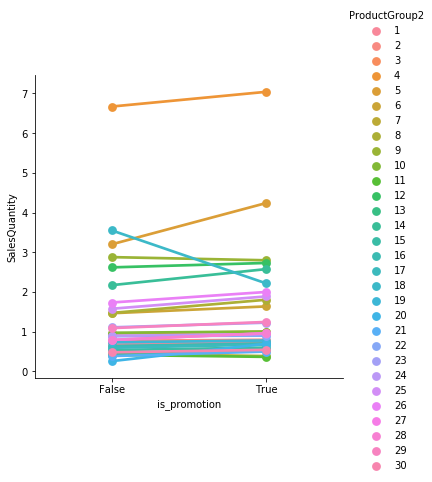

In [99]:
import seaborn as sns
sns.factorplot(data= weekly_pgroup_sales, 
               x= 'is_promotion',
               y= 'SalesQuantity',
               hue= 'ProductGroup2');

Some product groups are heavily affected by promotions.  

In [100]:
weekly_pgroup1_sales = all_data.groupby(['ProductGroup1','is_promotion'])['SalesQuantity'].mean()
weekly_pgroup1_sales=weekly_pgroup1_sales.reset_index()

C:\Users\Hp\Anaconda3\anac3\lib\site-packages\seaborn\categorical.py:3669: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



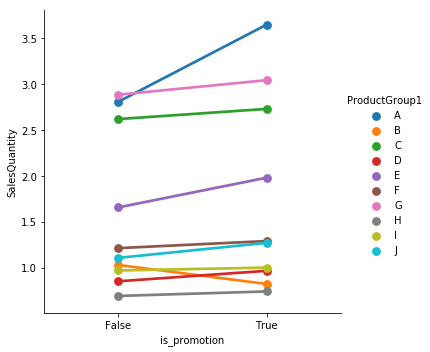

In [101]:
import seaborn as sns
sns.factorplot(data= weekly_pgroup1_sales, 
               x= 'is_promotion',
               y= 'SalesQuantity',
               hue= 'ProductGroup1');

A and E groups of items sell more during the promotion.

#### Day of week

In [32]:
import datetime as dt
all_data['day_of_week']=all_data.Date.dt.dayofweek

In [143]:
all_data['weekday']=all_data.Date.apply(lambda x: x.strftime('%A'))

In [168]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [170]:
table=(all_data.groupby(['weekday','promotions'])['SalesQuantity'].sum()).reset_index()

In [171]:
table = pd.pivot_table(table, values='SalesQuantity', index=['weekday'],
                    columns=['promotions'], aggfunc=np.mean, fill_value=0).reindex(cats)

In [172]:
fig = px.bar(table, x=table.index, y=table.columns, title="Total Sales Per Day of the Week with Promotions")
fig.show()

In [169]:
table=(all_data.groupby(['weekday','promotions'])['SalesQuantity'].mean()).reset_index()
table = pd.pivot_table(table, values='SalesQuantity', index=['weekday'],
                    columns=['promotions'], aggfunc=np.mean, fill_value=0).reindex(cats)
fig = px.bar(table, x=table.index, y=table.columns, title="Average Sales Per Day of the Week with Promotions")
fig.show()

Average promotional and non promotional sales increases on Friday and Saturday. Promotion 4 is the most effective on Saturday.

#### Months

In [33]:
all_data['months']=all_data.Date.dt.month
all_data['MONTHS']=all_data.Date.apply(lambda x: x.strftime('%b'))

In [159]:
cats = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']

In [158]:
all_data.MONTHS.unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'], dtype=object)

In [163]:
table=(all_data.groupby(['MONTHS','promotions'])['SalesQuantity'].mean()).reset_index()

In [164]:
table = pd.pivot_table(table, values='SalesQuantity', index=['MONTHS'],
                    columns=['promotions'], aggfunc=np.mean, fill_value=0).reindex(cats)

In [166]:
fig = px.bar(table, x=table.index, y=table.columns, title="Average Sales Per Month with Promotions")
fig.show()

On Jun, when promotion 4 and 3 are applied together, promotion 4 passed 3 on sales.

#### Daily Sales

In [174]:
z=(all_data.groupby(['promotions','Date'])['SalesQuantity'].sum()).reset_index()

In [176]:
table = pd.pivot_table(z, values='SalesQuantity', index=['Date'],
                    columns=['promotions'], aggfunc=np.mean, fill_value=0)

In [178]:
fig = px.bar(table, x=table.index, y=table.columns, title="Daily Total Sales Per Day")
fig.show()

Rahatlıkla görünüyor ki, promo 2'in getirdiği günlük satış sayısı en yüksek. Daha uzun dönem uygulansaydı en yüksek satışa ulaşabilme ihtimali yüksek.

## Feature Importance

In [181]:
all_data.columns

Index(['Date', 'StoreCode', 'ProductCode', 'SalesQuantity', 'ProductGroup1',
       'ProductGroup2', 'promotions', 'is_promotion', 'store_groups',
       'product_groups', 'is_returned', 'day_of_week', 'weekday', 'months',
       'MONTHS'],
      dtype='object')

In [191]:
all_data.head()

,Date,StoreCode,ProductCode,SalesQuantity,ProductGroup1,ProductGroup2,promotions,is_promotion,store_groups,product_groups,is_returned,day_of_week,weekday,months,MONTHS
0,2015-01-01,8,9,-1,H,15,No_Promo,False,medium,medium,True,3,Thursday,1,Jan
1,2015-01-01,131,9,1,H,15,No_Promo,False,medium,medium,False,3,Thursday,1,Jan
2,2015-01-01,144,9,2,H,15,No_Promo,False,slow,medium,False,3,Thursday,1,Jan
3,2015-01-01,203,9,2,H,15,No_Promo,False,slow,medium,False,3,Thursday,1,Jan
4,2015-01-01,256,9,0,H,15,No_Promo,False,fast,medium,False,3,Thursday,1,Jan


In [34]:
all_data.to_csv('all_data.csv')

In [192]:
df1=all_data[['StoreCode','promotions','weekday','months','SalesQuantity','ProductCode','ProductGroup1','ProductGroup2','is_promotion','store_groups','product_groups']]

C:\Users\Hp\Anaconda3\anac3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Hp\Anaconda3\anac3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Hp\Anaconda3\anac3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

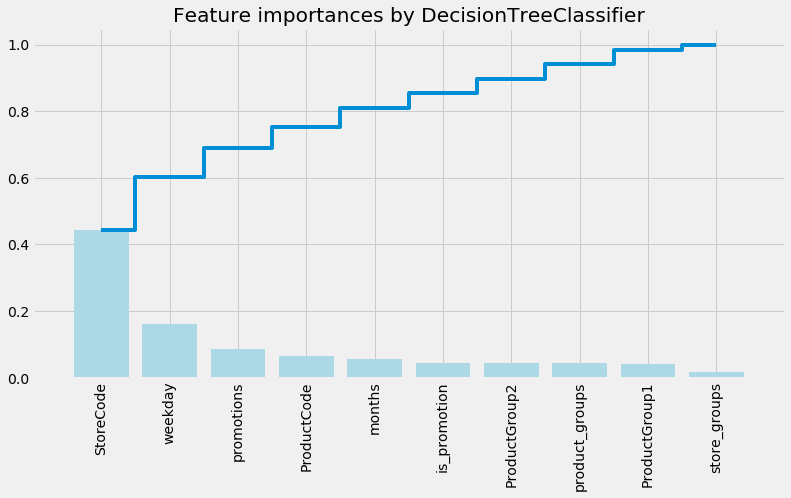

In [194]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)


# Convert these variables into categorical variables
df1["ProductGroup1"] = df1["ProductGroup1"].astype('category').cat.codes
df1["ProductGroup2"] = df1["ProductGroup2"].astype('category').cat.codes
df1["promotions"] = df1["promotions"].astype('category').cat.codes
df1["is_promotion"] = df1["is_promotion"].astype('category').cat.codes
df1["store_groups"] = df1["store_groups"].astype('category').cat.codes
df1["product_groups"] = df1["product_groups"].astype('category').cat.codes
df1["weekday"] = df1["weekday"].astype('category').cat.codes
df1["months"] = df1["months"].astype('category').cat.codes

# Create train and test splits
target_name = 'SalesQuantity'
X = df1.drop('SalesQuantity', axis=1)


y=df1[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123)

dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df1.drop(['SalesQuantity'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

According to the Decision tree classifier, the first factor that affects the individual sales is StoreCode, and the second factor is the day of week. As we have observed in the graphs above, some promotion types have brought more sales, some less. This attribution shows up on the graph. However, the presence or absence of the promotion had almost no effect on the sales volumes.

# Prediction Part

In [196]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [212]:
df=all_data[['Date','StoreCode','ProductCode','SalesQuantity']]

df3 is the test data, let's merge this dataset two our training data.

In [213]:
df3.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-08-01,2,9,1
1,2015-08-01,7,9,1
2,2015-08-01,62,9,1
3,2015-08-01,181,9,1
4,2015-08-01,6,20,1


In [217]:
df1.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-01-01,8,9,-1
1,2015-01-01,131,9,1
2,2015-01-01,144,9,2
3,2015-01-01,203,9,2
4,2015-01-01,256,9,0


## Prediction with promotion 5 info

In [338]:
result = df1.append(df3, sort=False)

In [270]:
df4

,Period,StartDate,EndDate
0,Promo1,2015-02-10,2015-02-17
1,Promo2,2015-03-15,2015-03-22
2,Promo3,2015-05-24,2015-06-01
3,Promo4,2015-06-21,2015-06-28
4,Promo5,2015-01-09,2015-06-09
5,Promo6,2015-11-20,2015-11-27


In [318]:
result.reset_index(inplace=True)
import numpy as np
promotions=[
    (result['Date']<='2015-02-17')&(result['Date']>='2015-02-10'),
    (result['Date']<='2015-03-22')&(result['Date']>='2015-03-15'),
    (result['Date']<='2015-06-01')&(result['Date']>='2015-05-24'),
    (result['Date']<='2015-06-28')&(result['Date']>='2015-06-21'),
    (result['Date']<='2015-06-09')&(result['Date']>='2015-01-09')]
labels=['Promo_1','Promo_2','Promo_3','Promo_4','Promo_5']
result['promotions'] = np.select(promotions, labels)

In [300]:
result.set_index('Date',inplace=True)

In [319]:
result.promotions=result.promotions.replace(['0'],['No_Promo'])

In [321]:
result["promotions"] = result["promotions"].astype('category').cat.codes

In [327]:
result.set_index('Date',inplace=True)

In [328]:
split_date = '2015-8-1'
df_train = result.loc[result.index < split_date].copy()
df_test = result.loc[result.index > split_date].copy()

In [330]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['StoreCode','promotions','dayofweek','ProductCode','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [331]:
X_train, y_train = create_features(df_train, label='SalesQuantity')
X_test, y_test = create_features(df_test, label='SalesQuantity')

C:\Users\Hp\Anaconda3\anac3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [332]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=1000, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

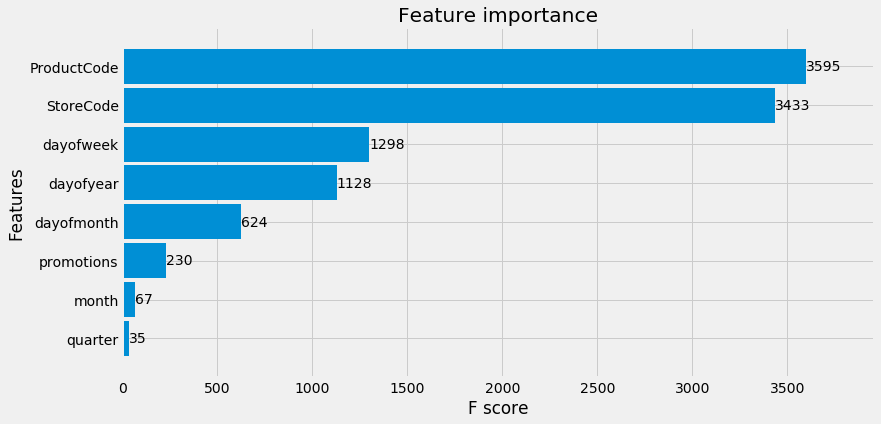

In [333]:
_ = plot_importance(reg, height=0.9)

In [334]:
df_test['MY_Prediction'] = reg.predict(X_test)
all_set = pd.concat([df_test, df_train], sort=False)

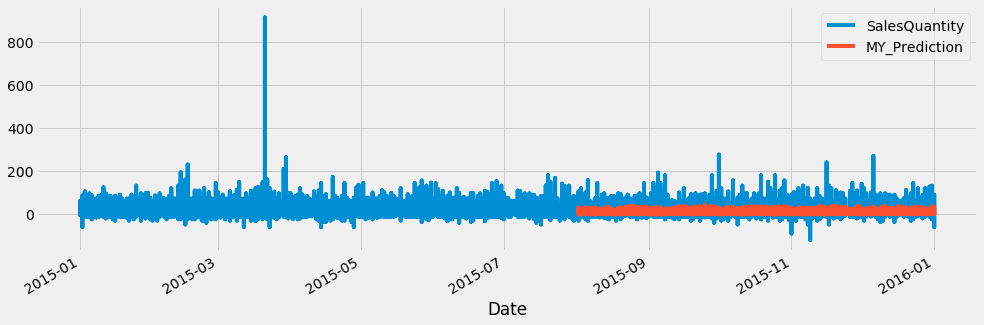

In [335]:
_ = all_set[['SalesQuantity','MY_Prediction']].plot(figsize=(15, 5))

In [351]:
error=mean_squared_error(y_true=df_test['SalesQuantity'],
                   y_pred=df_test['MY_Prediction'])

In [354]:
print('The RMSE is {}'. format(sqrt(error)))

The RMSE is 4.255548955304169


## Prediction Without Promo 5 info

In [339]:
result.reset_index(inplace=True)
import numpy as np
promotions=[
    (result['Date']<='2015-02-17')&(result['Date']>='2015-02-10'),
    (result['Date']<='2015-03-22')&(result['Date']>='2015-03-15'),
    (result['Date']<='2015-06-01')&(result['Date']>='2015-05-24'),
    (result['Date']<='2015-06-28')&(result['Date']>='2015-06-21'),]
labels=['Promo_1','Promo_2','Promo_3','Promo_4']
result['promotions'] = np.select(promotions, labels)

In [340]:
result.set_index('Date',inplace=True)

In [341]:
result.promotions=result.promotions.replace(['0'],['No_Promo'])

In [342]:
result["promotions"] = result["promotions"].astype('category').cat.codes

In [343]:
split_date = '2015-8-1'
df_train = result.loc[result.index < split_date].copy()
df_test = result.loc[result.index > split_date].copy()

In [344]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['StoreCode','promotions','dayofweek','ProductCode','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [345]:
X_train, y_train = create_features(df_train, label='SalesQuantity')
X_test, y_test = create_features(df_test, label='SalesQuantity')

C:\Users\Hp\Anaconda3\anac3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [346]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=1000, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

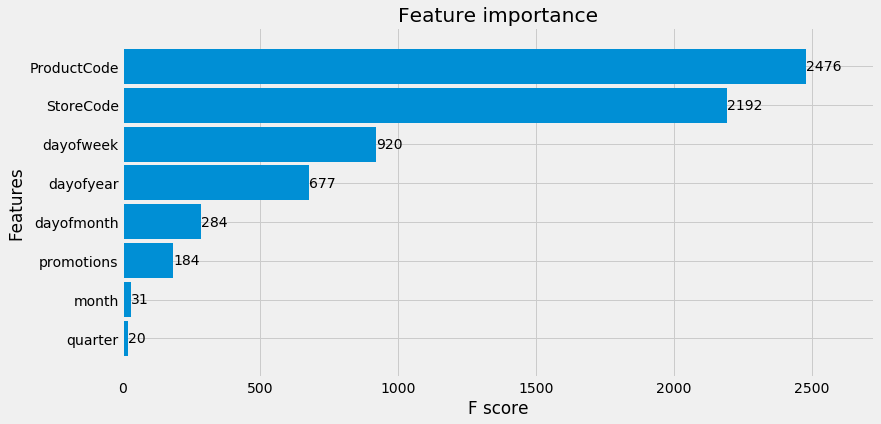

In [347]:
_ = plot_importance(reg, height=0.9)

In [348]:
df_test['MY_Prediction'] = reg.predict(X_test)
all_set = pd.concat([df_test, df_train], sort=False)

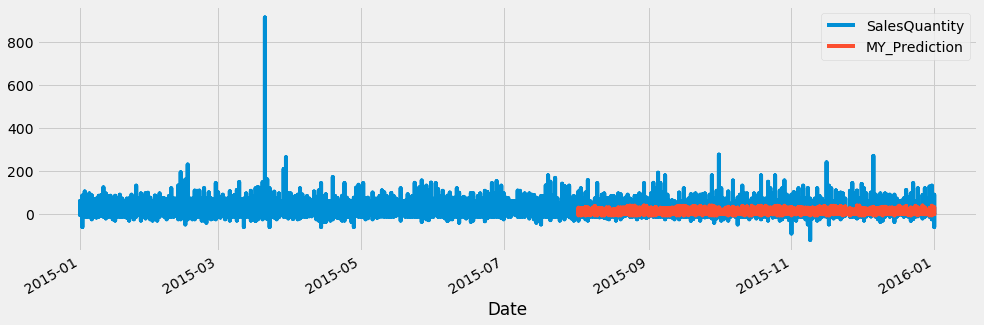

In [349]:
_ = all_set[['SalesQuantity','MY_Prediction']].plot(figsize=(15, 5))

In [356]:
error=mean_squared_error(y_true=df_test['SalesQuantity'],
                   y_pred=df_test['MY_Prediction'])

In [357]:
print('The RMSE is {}'. format(sqrt(error)))

The RMSE is 4.255548955304169
